In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import pmdarima as pm
from pmdarima import auto_arima
from common.preprocessor import load_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv('data/Diarrhoea_Incidence_Data.csv',
                   parse_dates=True, index_col='Date')
data.head()

,Record
Date,
2008-01-01,36122
2008-02-01,37215
2008-03-01,33000
2008-04-01,35952
2008-05-01,34236


In [16]:
data= data.reindex(pd.date_range(start='2008-01-01', end='2022-03-01', freq="MS"))
data

,Record
2008-01-01,36122
2008-02-01,37215
2008-03-01,33000
2008-04-01,35952
2008-05-01,34236
...,...
2021-11-01,106333
2021-12-01,98320
2022-01-01,91401
2022-02-01,105399


In [17]:
data.dtypes

Record    int64
dtype: object

In [18]:
data.describe()

,Record
count,171.000000
mean,102598.707602
std,32283.352466
min,33000.000000
25%,85167.500000
50%,113154.000000
75%,126913.500000
max,160240.000000


<Axes: >

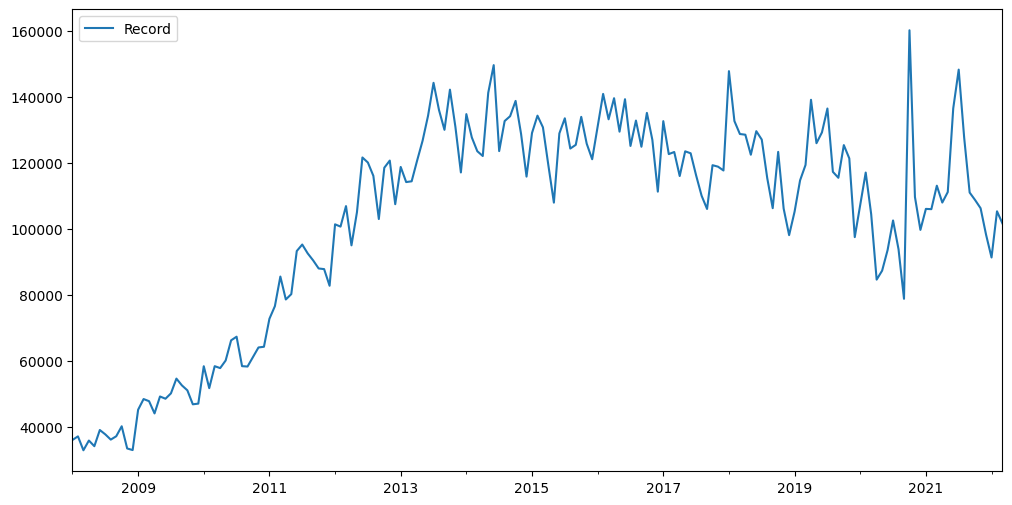

In [19]:
data.plot(figsize=(12,6))

In [20]:
#scale data with min max scaler
scaler = MinMaxScaler()
scaled_data = data.copy()
scaled_data.head()

,Record
2008-01-01,36122
2008-02-01,37215
2008-03-01,33000
2008-04-01,35952
2008-05-01,34236


In [21]:
scaled_data= scaler.fit_transform(scaled_data[['Record']])
print(scaled_data.shape)

(171, 1)


In [28]:
# Convert numpy array back to DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns)

In [29]:
# Check for stationarity with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("=============================\nData may be non-stationary. \nConsider differencing.")

print("Testing stationarity of scaled data:")
adf_test(scaled_data)

Testing stationarity of scaled data:
ADF Statistic: -2.7329822104467185
p-value: 0.06850272258071602
Data may be non-stationary. 
Consider differencing.


In [32]:
# Identify number of differences required (if necessary)
n_diffs = pm.arima.ndiffs(scaled_data_df['Record'], test='adf')
print(f"\nNumber of differences required for scaled data: {n_diffs}")



Number of differences required for scaled data: 1


In [35]:
# Perform differencing if required
if n_diffs > 0:
    differenced_data = pd.DataFrame(scaled_data).diff(n_diffs).dropna()
else:
    differenced_data = pd.DataFrame(scaled_data).copy()


In [37]:
differenced_data

,0
1,0.008590
2,-0.033126
3,0.023200
4,-0.013486
5,0.038533
...,...
166,-0.019412
167,-0.062975
168,-0.054378
169,0.110013


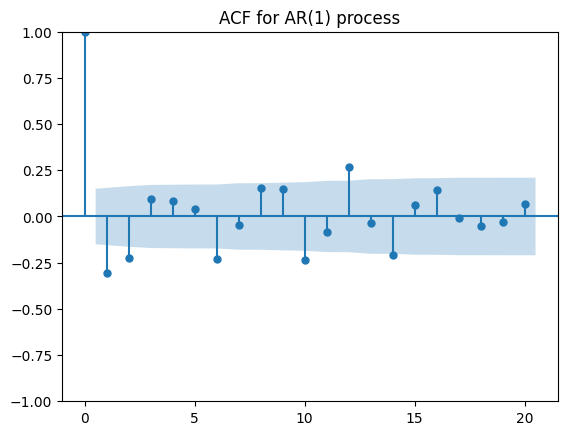

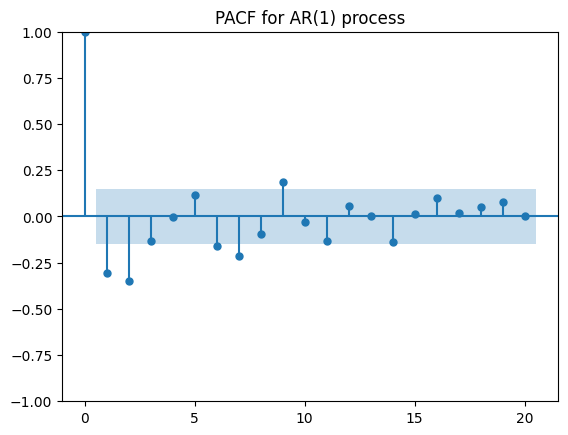

In [38]:
# ACF and PACF plots (optional)
plot_acf(differenced_data, lags=20, title='ACF for AR(1) process')
plt.show()
plot_pacf(differenced_data, lags=20, title='PACF for AR(1) process')
plt.show()

In [39]:
# Use auto_arima to find best parameters
model = auto_arima(differenced_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True)
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-335.511, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-227.536, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-310.199, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-229.524, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-336.621, Time=0.87 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-319.197, Time=0.79 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-332.997, Time=1.84 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-332.801, Time=1.80 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-335.917, Time=1.59 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-331.344, Time=1.67 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=-332.357, Time=1.98 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-335.482, Time=0.51 sec
 ARIMA(1,0,0)(1,1,1)[12] inte